In [53]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
import plotly.express as px
import cufflinks as cf
cf.go_offline()
from sklearn.model_selection import train_test_split
style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer

%matplotlib inline

In [54]:
df=pd.read_csv('Train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [55]:
df.shape

(8523, 12)

In [56]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [57]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800




#### Item_Visibility column has 0 values. It is not practical , so we will treat them as null values.

In [58]:
df['Item_Visibility'].replace(0, np.nan, inplace=True)

In [59]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility               526
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [60]:
round(df.isnull().sum()/len(df)*100)

Item_Identifier               0.0
Item_Weight                  17.0
Item_Fat_Content              0.0
Item_Visibility               6.0
Item_Type                     0.0
Item_MRP                      0.0
Outlet_Identifier             0.0
Outlet_Establishment_Year     0.0
Outlet_Size                  28.0
Outlet_Location_Type          0.0
Outlet_Type                   0.0
Item_Outlet_Sales             0.0
dtype: float64



#### Item_weight has 17% null values, Item_Visibility has 6% null values and Outlet_Size has 28% null values

In [61]:
for column in df:
    print(column, len(df[column].unique()))

Item_Identifier 1559
Item_Weight 416
Item_Fat_Content 5
Item_Visibility 7880
Item_Type 16
Item_MRP 5938
Outlet_Identifier 10
Outlet_Establishment_Year 9
Outlet_Size 4
Outlet_Location_Type 3
Outlet_Type 4
Item_Outlet_Sales 3493


In [62]:
for column in df:
    if len(df[column].unique())<=20:
        print(column, df[column].unique())

Item_Fat_Content ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Establishment_Year [1999 2009 1998 1987 1985 2002 2007 1997 2004]
Outlet_Size ['Medium' nan 'High' 'Small']
Outlet_Location_Type ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']




#### Values in Item_Fat_Content is not proper way, so we have to fix it

In [63]:
df['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace=True)
df['Item_Fat_Content'].replace('LF', 'Low Fat', inplace=True)
df['Item_Fat_Content'].replace('reg', 'Low Fat', inplace=True)

In [64]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [65]:
df['Item_Identifier']=df['Item_Identifier'].apply(lambda x : x[:2])

In [66]:
df['Item_Identifier'].unique()

array(['FD', 'DR', 'NC'], dtype=object)



#### FD - Food, DR - Drink, NC - Non Consumable



#### Let's add a new feature that would have the number of years the outlet has been in operation till 2013. (This dataset is from 2013). 

In [67]:
df['Outlet_Age']=2013-df['Outlet_Establishment_Year']
df=df.drop(columns=['Outlet_Establishment_Year'])

In [68]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FD,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,14
1,DR,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,4
2,FD,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,14
3,FD,19.20,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store,732.3800,15
4,NC,8.93,Low Fat,NaN,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,26



#### We will convert Item_Fat_Content values having Item_Identifier= 'NC' by 'Non Edible'

In [69]:
df[df['Item_Identifier']=='NC']['Item_Type'].unique()

array(['Household', 'Health and Hygiene', 'Others'], dtype=object)

In [70]:
df.loc[df['Item_Identifier']=="NC",'Item_Fat_Content']='Non Edible'

In [71]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FD,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,14
1,DR,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,4
2,FD,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,14
3,FD,19.20,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store,732.3800,15
4,NC,8.93,Non Edible,NaN,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,26


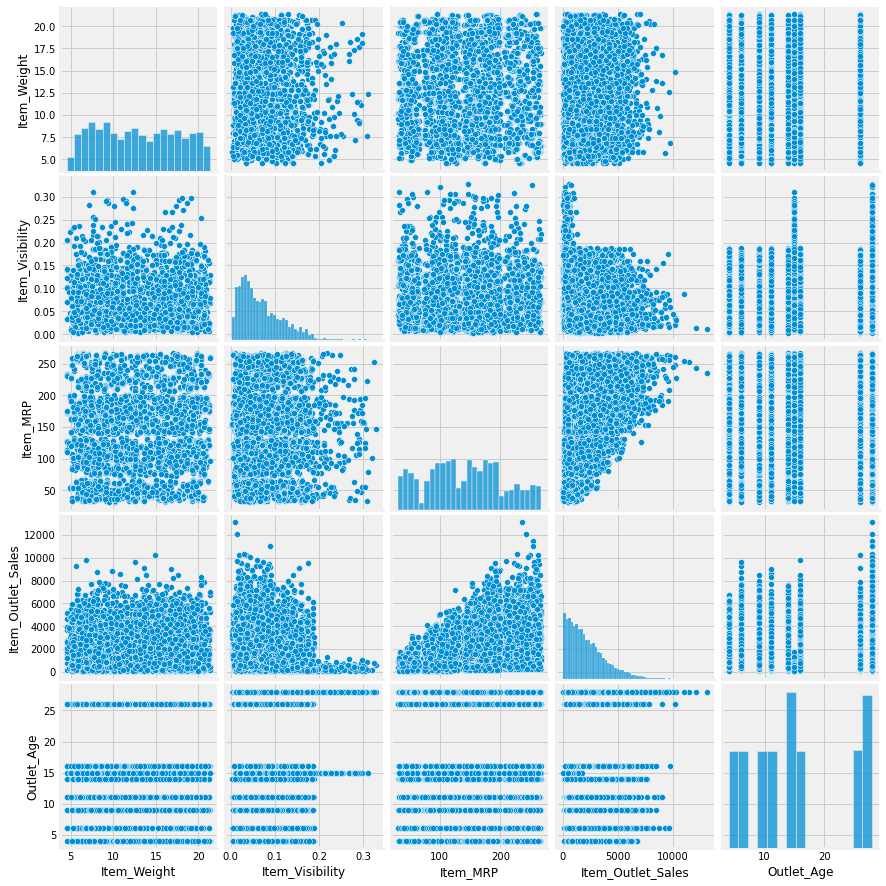

In [72]:
sns.pairplot(df)

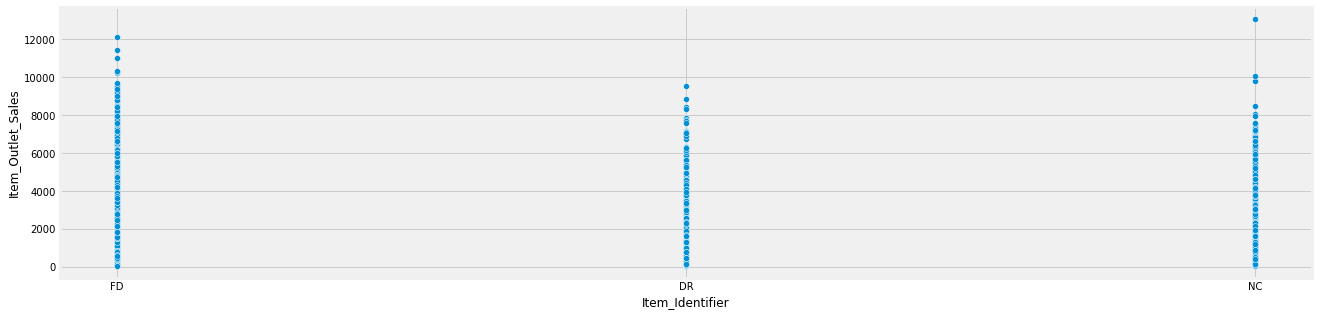

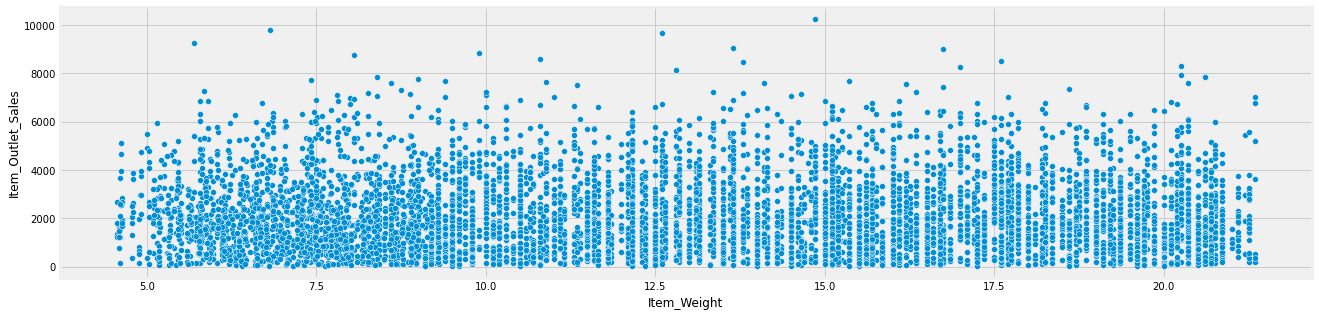

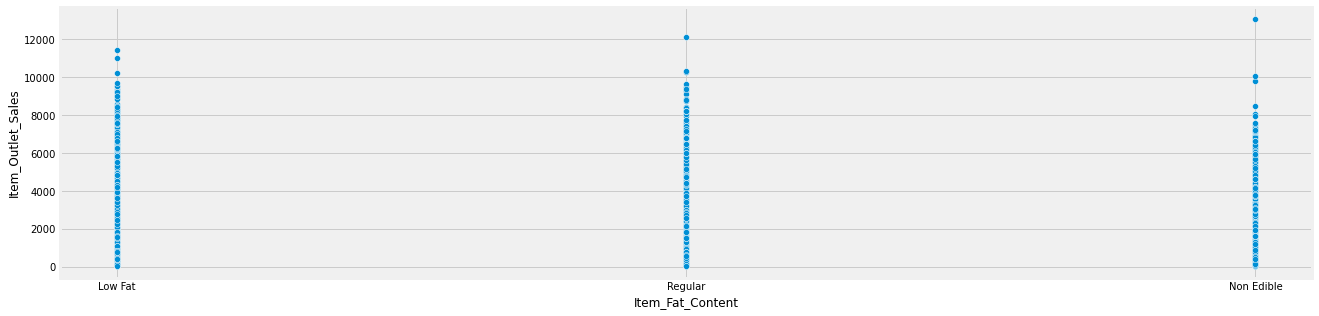

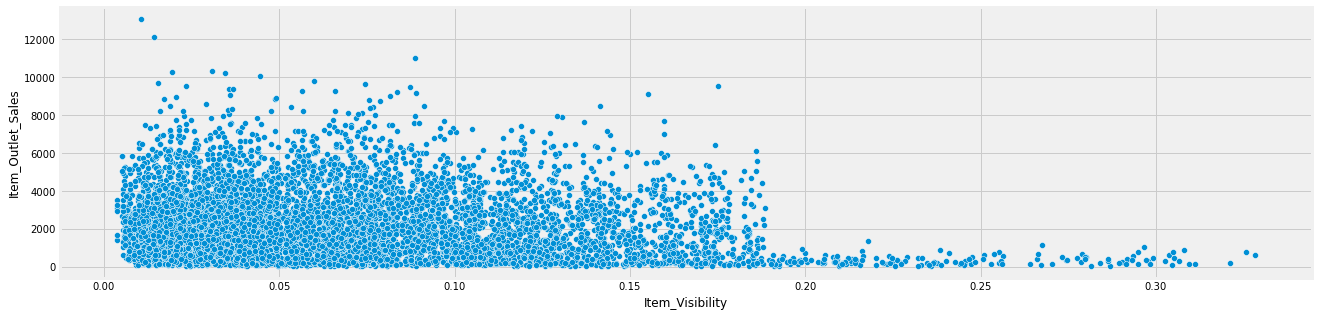

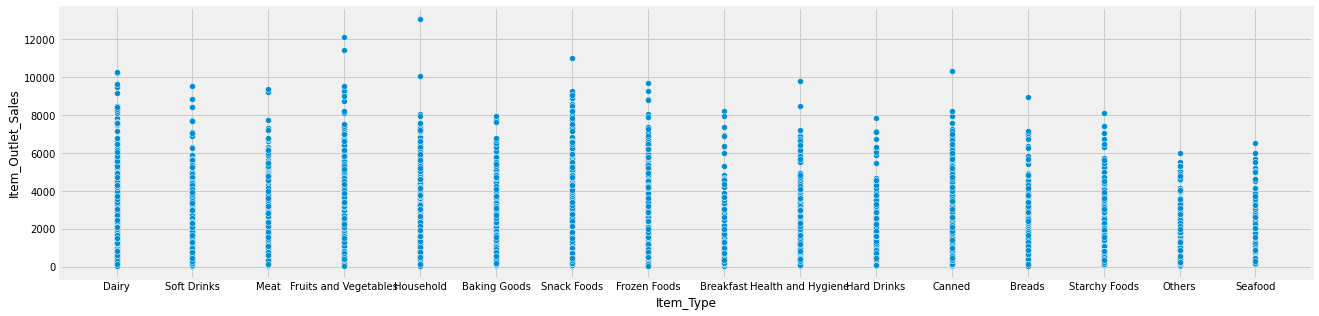

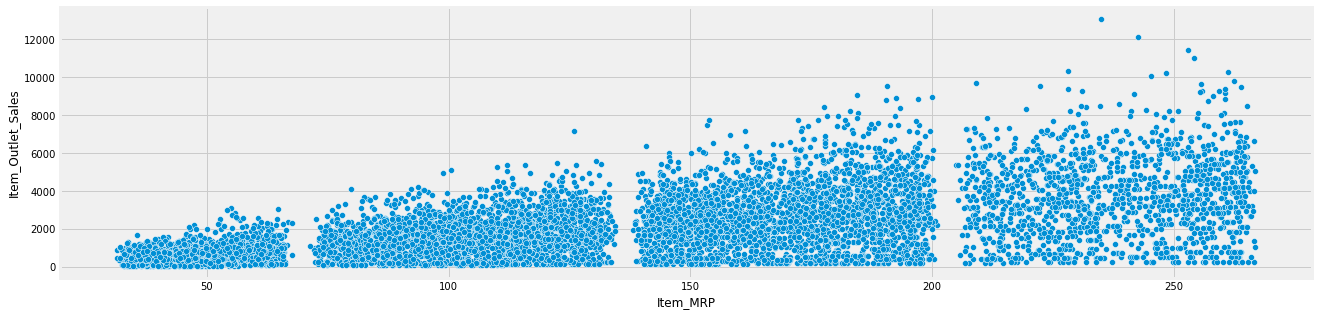

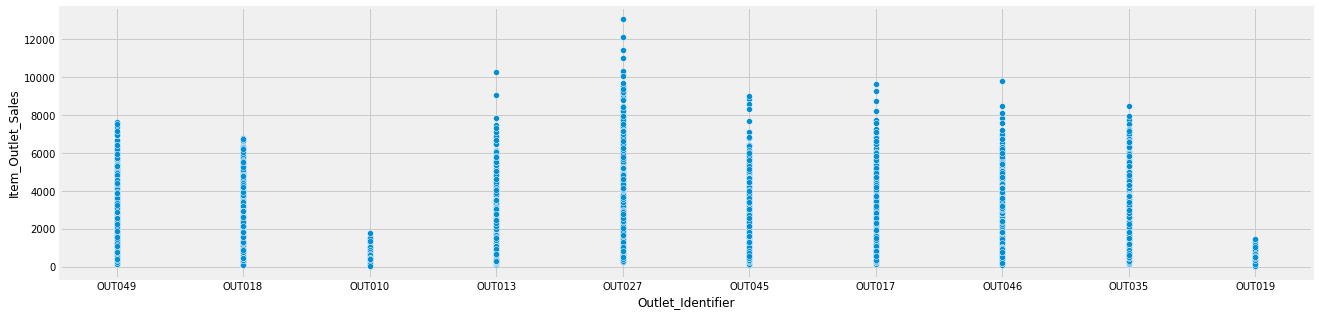

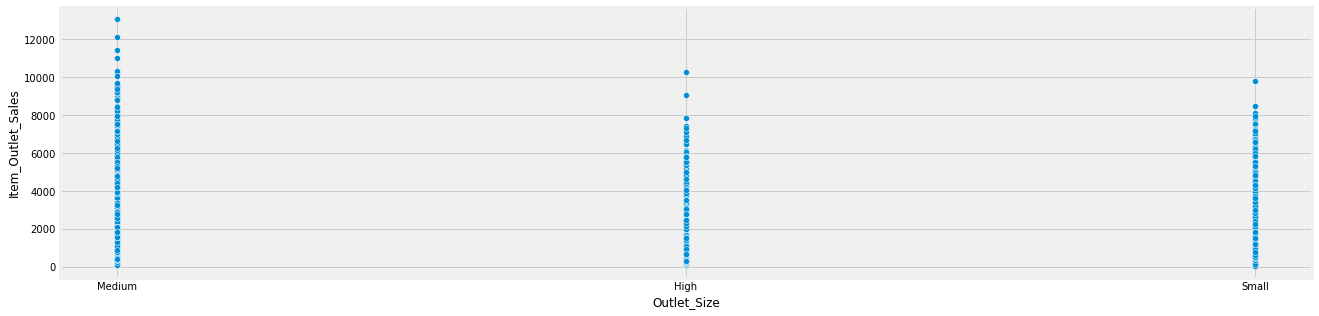

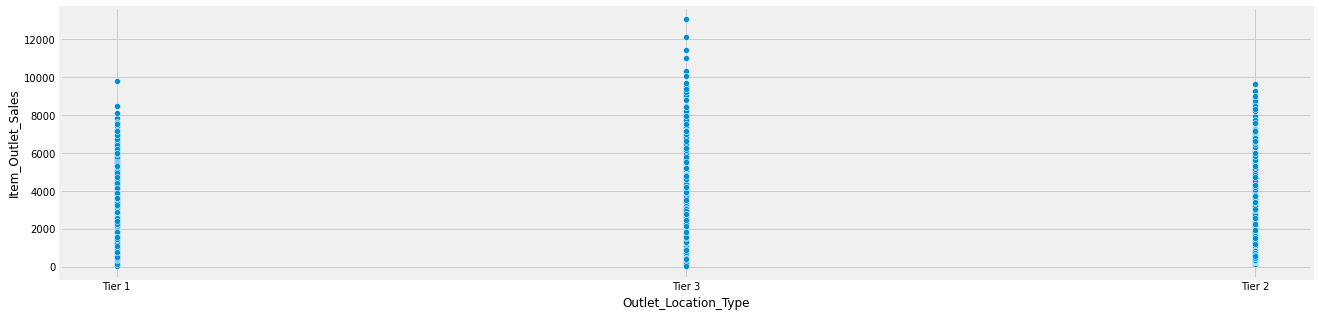

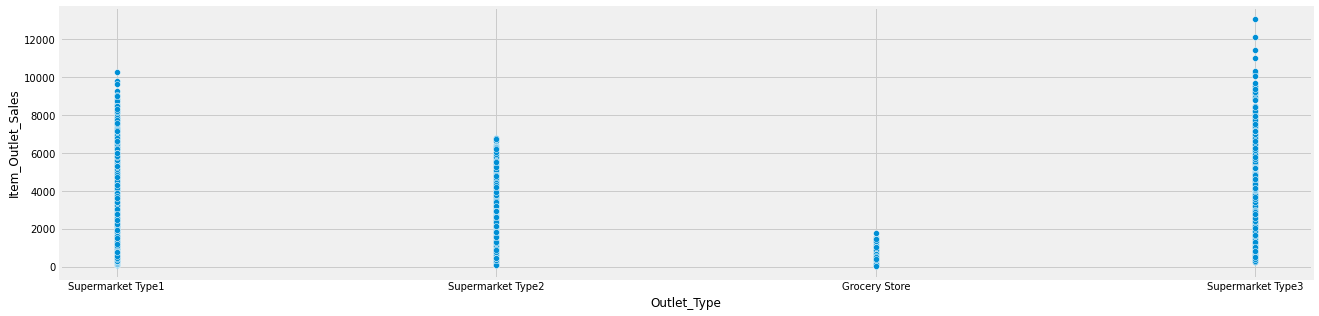

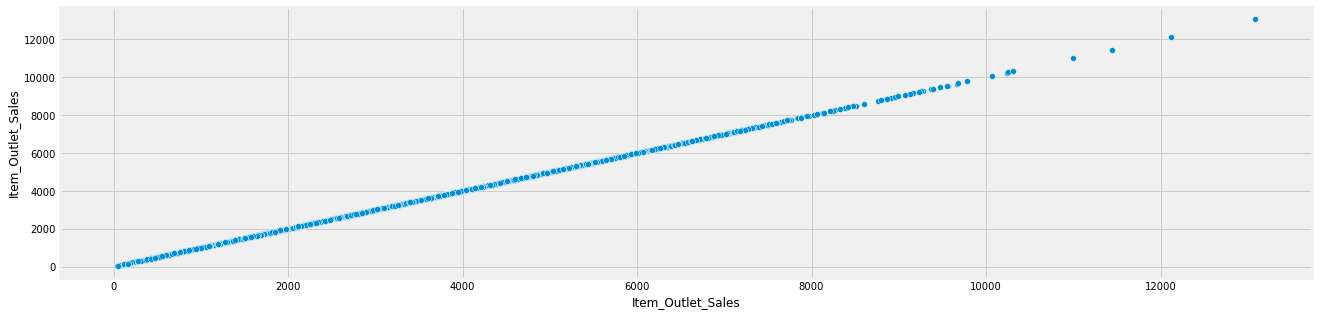

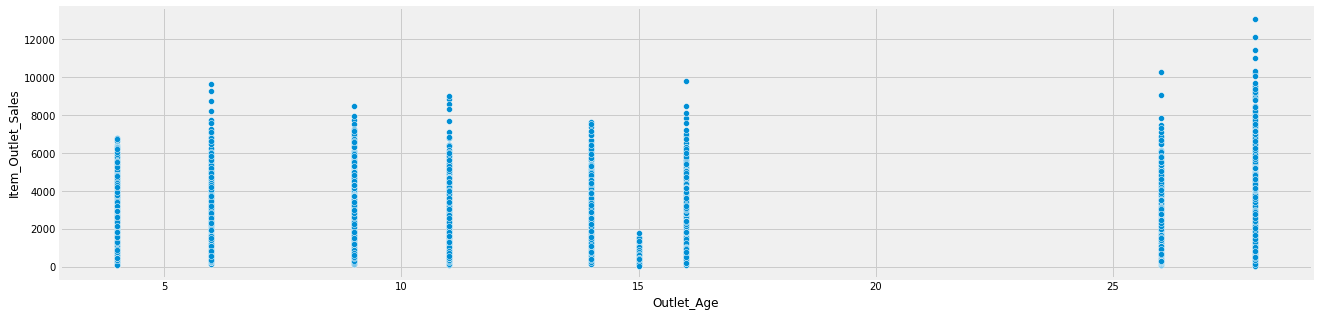

In [73]:
for column in df:
    plt.figure(figsize=(20,5))
    sns.scatterplot(data=df, x=column, y='Item_Outlet_Sales')
    plt.show()

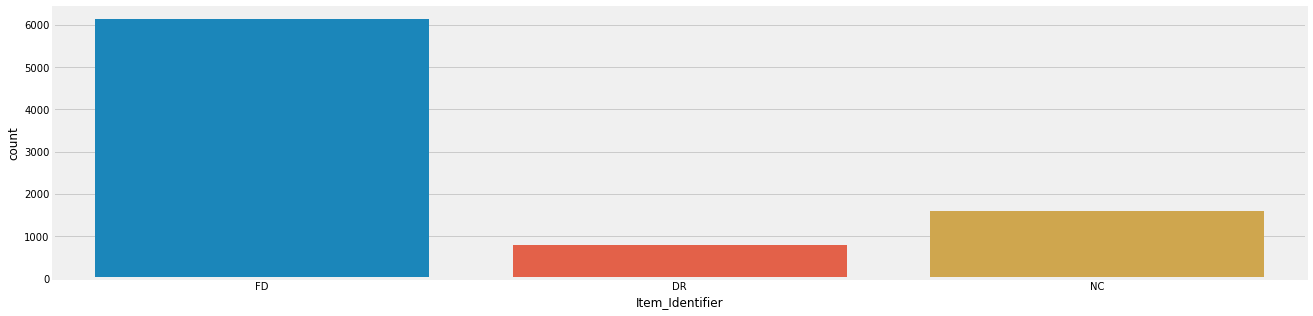

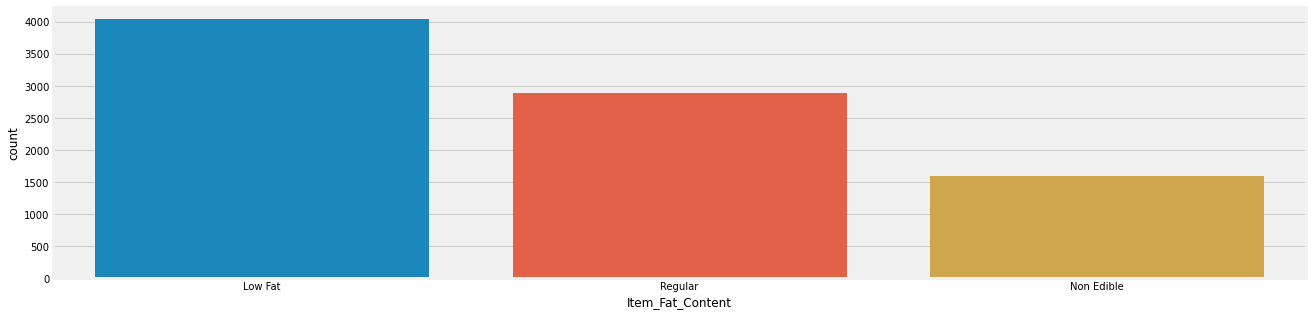

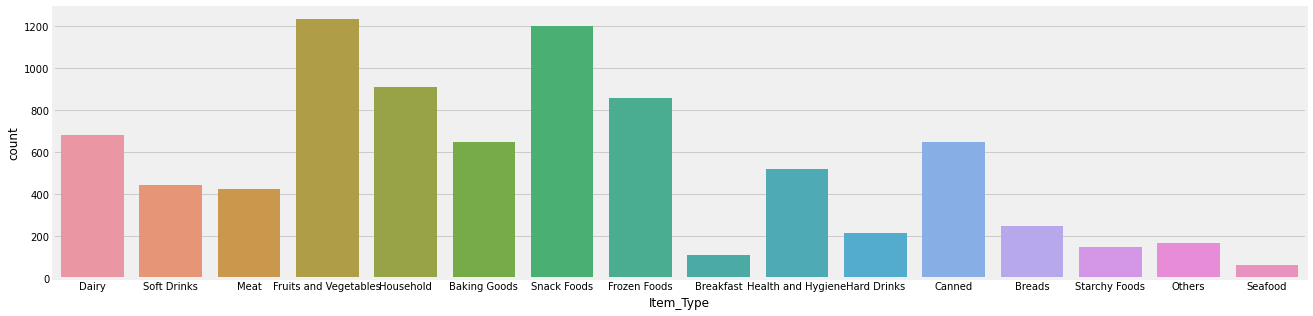

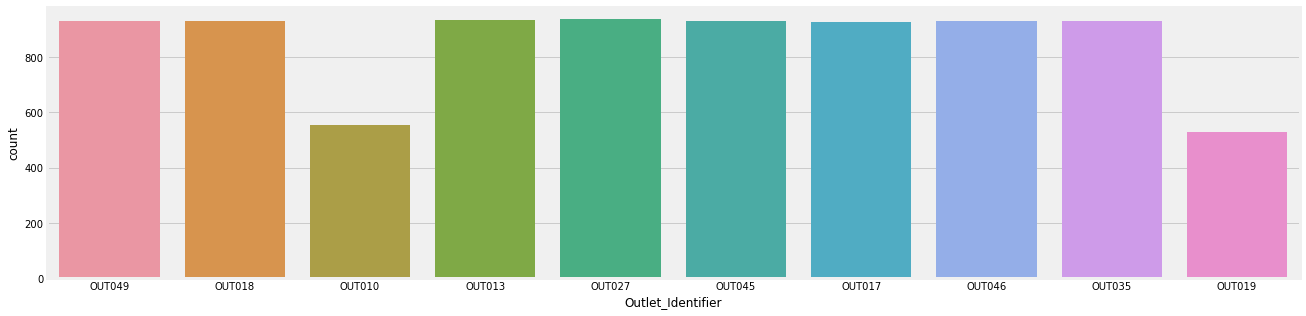

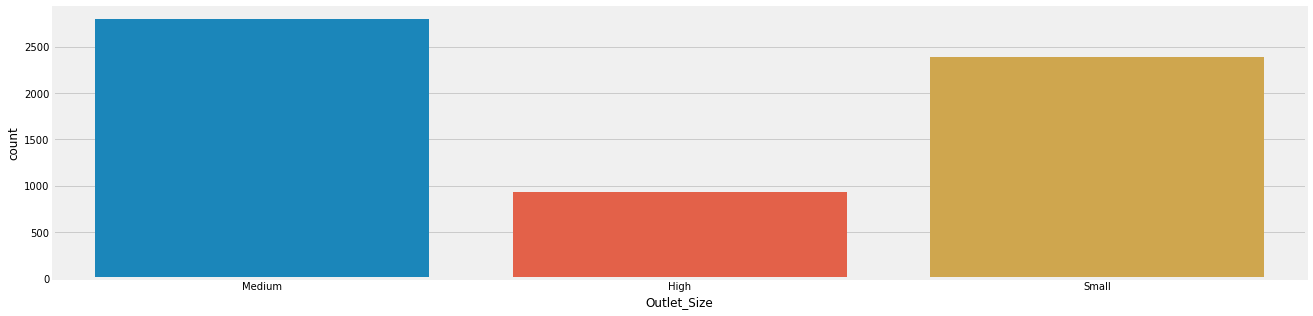

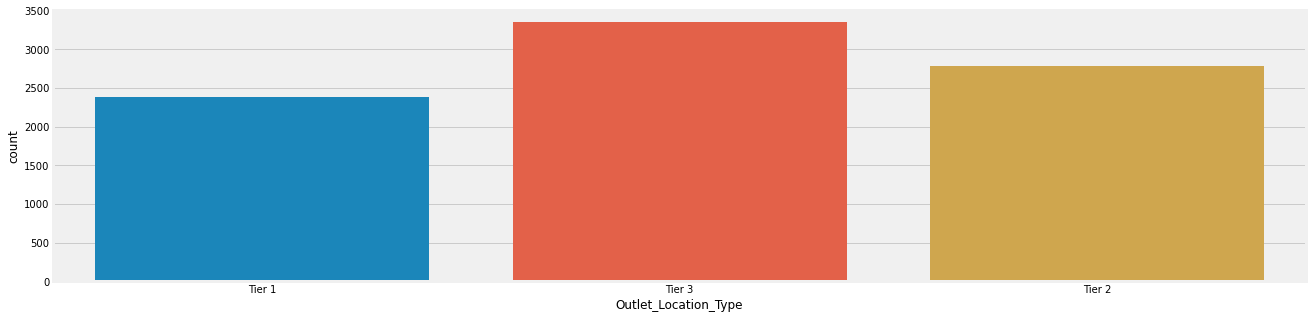

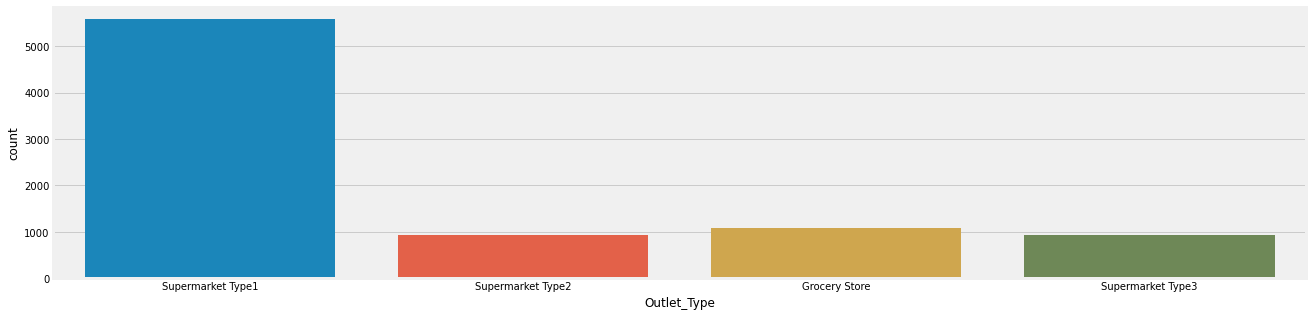

In [74]:
for column in df.select_dtypes('object'):
    plt.figure(figsize=(20,5))
    sns.countplot(x=df[column])
    plt.show()

In [75]:
pd.DataFrame(df.groupby('Outlet_Type').sum()['Item_Outlet_Sales'].sort_values(ascending=False))

,Item_Outlet_Sales
Outlet_Type,
Supermarket Type1,1.291734e+07
Supermarket Type3,3.453926e+06
Supermarket Type2,1.851823e+06
Grocery Store,3.680343e+05


In [76]:
pd.DataFrame(df.groupby('Outlet_Type').mean()['Item_Outlet_Sales'].sort_values(ascending=False))

,Item_Outlet_Sales
Outlet_Type,
Supermarket Type3,3694.038558
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Grocery Store,339.828500


In [77]:
pd.DataFrame(df.groupby('Outlet_Location_Type').sum()['Item_Outlet_Sales'].sort_values(ascending=False))

,Item_Outlet_Sales
Outlet_Location_Type,
Tier 3,7.636753e+06
Tier 2,6.472314e+06
Tier 1,4.482059e+06


In [78]:
pd.DataFrame(df.groupby('Outlet_Location_Type').mean()['Item_Outlet_Sales'].sort_values(ascending=False))

,Item_Outlet_Sales
Outlet_Location_Type,
Tier 2,2323.990559
Tier 3,2279.627651
Tier 1,1876.909159


In [79]:
pd.DataFrame(df.groupby('Outlet_Size').sum()['Item_Outlet_Sales'].sort_values(ascending=False))

,Item_Outlet_Sales
Outlet_Size,
Medium,7.489719e+06
Small,4.566212e+06
High,2.142664e+06


In [80]:
pd.DataFrame(df.groupby('Outlet_Size').mean()['Item_Outlet_Sales'].sort_values(ascending=False))

,Item_Outlet_Sales
Outlet_Size,
Medium,2681.603542
High,2298.995256
Small,1912.149161


In [81]:
pd.DataFrame(df.groupby('Outlet_Identifier').sum()['Item_Outlet_Sales'].sort_values(ascending=False))

,Item_Outlet_Sales
Outlet_Identifier,
OUT027,3.453926e+06
OUT035,2.268123e+06
OUT049,2.183970e+06
OUT017,2.167465e+06
OUT013,2.142664e+06
OUT046,2.118395e+06
OUT045,2.036725e+06
OUT018,1.851823e+06
OUT010,1.883402e+05


In [82]:
pd.DataFrame(df.groupby('Outlet_Identifier').mean()['Item_Outlet_Sales'].sort_values(ascending=False))

,Item_Outlet_Sales
Outlet_Identifier,
OUT027,3694.038558
OUT035,2438.841866
OUT049,2348.354635
OUT017,2340.675263
OUT013,2298.995256
OUT046,2277.844267
OUT045,2192.384798
OUT018,1995.498739
OUT019,340.329723


In [83]:
pd.DataFrame(df.groupby(['Outlet_Type', 'Outlet_Identifier']).size(), columns=['Size'])

Size
Outlet_Type       Outlet_Identifier      
Grocery Store     OUT010              555
                  OUT019              528
Supermarket Type1 OUT013              932
                  OUT017              926
                  OUT035              930
                  OUT045              929
                  OUT046              930
                  OUT049              930
Supermarket Type2 OUT018              928
Supermarket Type3 OUT027              935

In [84]:
pd.DataFrame(df.groupby(['Outlet_Type', 'Outlet_Size']).size(), columns=['Size'])

Size
Outlet_Type       Outlet_Size      
Grocery Store     Small         528
Supermarket Type1 High          932
                  Medium        930
                  Small        1860
Supermarket Type2 Medium        928
Supermarket Type3 Medium        935

In [85]:
pd.DataFrame(df.groupby(['Outlet_Location_Type', 'Outlet_Type']).size(), columns=['Size'])

Size
Outlet_Location_Type Outlet_Type            
Tier 1               Grocery Store       528
                     Supermarket Type1  1860
Tier 2               Supermarket Type1  2785
Tier 3               Grocery Store       555
                     Supermarket Type1   932
                     Supermarket Type2   928
                     Supermarket Type3   935

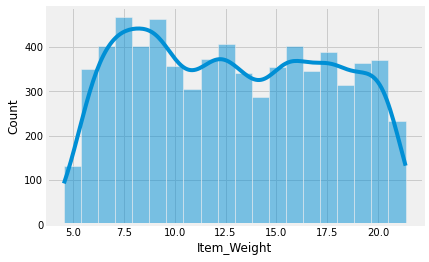

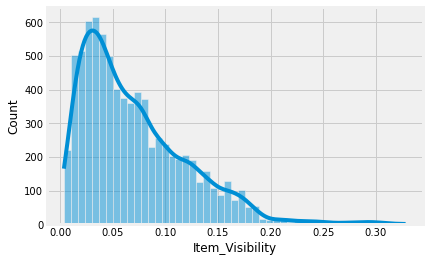

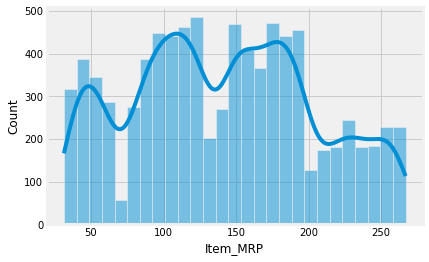

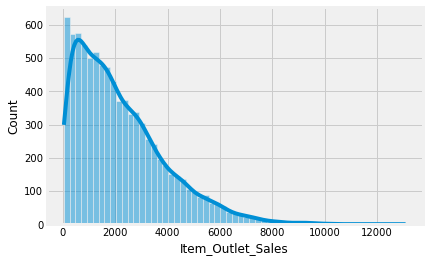

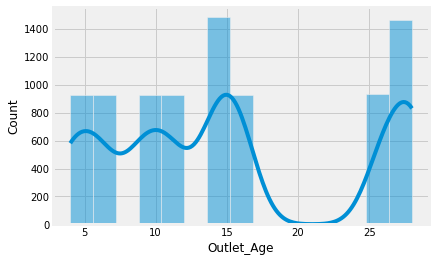

In [86]:
for column in df.select_dtypes(['int64', 'float64']):
    sns.histplot(x=df[column], kde=True)
    plt.show()

In [87]:
data=df.copy()
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FD,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,14
1,DR,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,4
2,FD,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,14
3,FD,19.20,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store,732.3800,15
4,NC,8.93,Non Edible,NaN,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,26


# Dropping Unnecessary Column

In [88]:
data=data.drop(columns=['Item_Type'])

# Encoding Categorical Values

In [89]:
data['Outlet_Size']=data['Outlet_Size'].map({'Small':0, 'Medium': 1, 'High': 2})

In [90]:
onehot_col=['Item_Identifier', 'Item_Fat_Content', 'Outlet_Identifier', 'Outlet_Type', 'Outlet_Location_Type']
onehot_enc=OneHotEncoder(drop="first", sparse=False)
enc_array=onehot_enc.fit_transform(data[onehot_col])

In [91]:
enc_df=pd.DataFrame(enc_array, columns=onehot_enc.get_feature_names_out())
enc_df

,Item_Identifier_FD,Item_Identifier_NC,Item_Fat_Content_Non Edible,Item_Fat_Content_Regular,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8519,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8520,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8521,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [92]:
data=data.drop(columns=onehot_col)

In [93]:
data=pd.concat([data, enc_df], axis=1)

In [94]:
data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Outlet_Age,Item_Identifier_FD,Item_Identifier_NC,Item_Fat_Content_Non Edible,Item_Fat_Content_Regular,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,9.30,0.016047,249.8092,1.0,3735.1380,14,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,5.92,0.019278,48.2692,1.0,443.4228,4,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,17.50,0.016760,141.6180,1.0,2097.2700,14,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,19.20,NaN,182.0950,NaN,732.3800,15,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8.93,NaN,53.8614,2.0,994.7052,26,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Imputing Missing Values

In [95]:
imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
new_array=imputer.fit_transform(data) # impute the missing values
new_data=pd.DataFrame(data=new_array, columns=data.columns)

In [96]:
new_data['Outlet_Size']=np.round(new_data['Outlet_Size'])

In [97]:
new_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Outlet_Age,Item_Identifier_FD,Item_Identifier_NC,Item_Fat_Content_Non Edible,Item_Fat_Content_Regular,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,9.30,0.016047,249.8092,1.0,3735.1380,14.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,5.92,0.019278,48.2692,1.0,443.4228,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,17.50,0.016760,141.6180,1.0,2097.2700,14.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,19.20,0.111285,182.0950,0.0,732.3800,15.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8.93,0.067568,53.8614,2.0,994.7052,26.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Outlier

<AxesSubplot:>

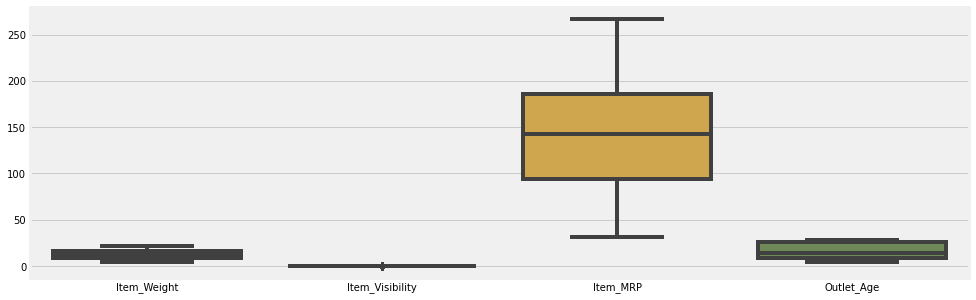

In [98]:
num_cols=['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']
plt.figure(figsize=(15,5))
sns.boxplot(data=new_data[num_cols])



##### Note: We dont have much outlier, so no need to remove data

# Correlation

<AxesSubplot:>

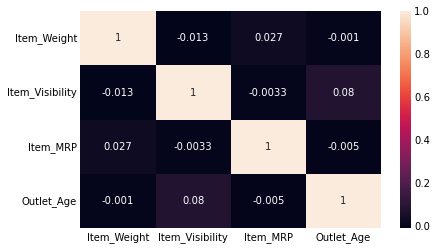

In [99]:
sns.heatmap(new_data[num_cols].corr(), annot=True)



##### Here is not significant correlation to drop any column

# Scaling Numeric Values

In [100]:
num_cols=['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']
num_df=new_data[num_cols]
cat_output_df=new_data.drop(columns=num_cols) #categorical and output columns

In [101]:
scaler=StandardScaler()
num_array=scaler.fit_transform(num_df)
num_df=pd.DataFrame(num_array, columns=num_df.columns)

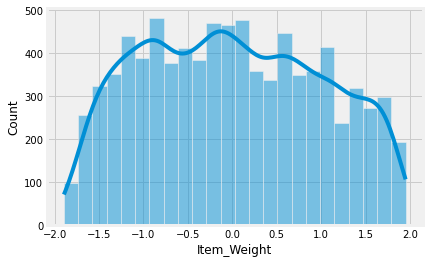

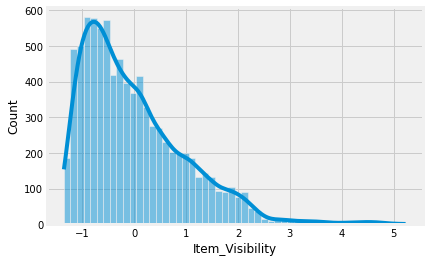

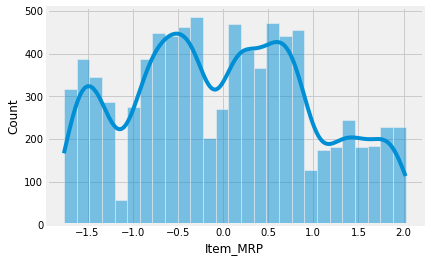

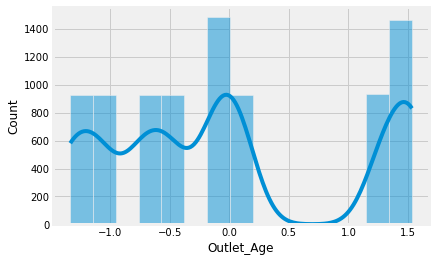

In [102]:
for column in num_df:
    sns.histplot(num_df[column], kde=True)
    plt.show()

# Final data

In [103]:
final_data=pd.concat([num_df, cat_output_df], axis=1)

In [104]:
final_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age,Outlet_Size,Item_Outlet_Sales,Item_Identifier_FD,Item_Identifier_NC,Item_Fat_Content_Non Edible,Item_Fat_Content_Regular,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3
0,-0.808650,-1.102720,1.747454,-0.139541,1.0,3735.1380,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,-1.582533,-1.037231,-1.489023,-1.334103,1.0,443.4228,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.068818,-1.088272,0.010040,-0.139541,1.0,2097.2700,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.458049,0.827700,0.660050,-0.020085,0.0,732.3800,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.893365,-0.058422,-1.399220,1.293934,2.0,994.7052,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
